In [1]:
from pryngles import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Save in a temporary file

In [3]:
from tempfile import NamedTemporaryFile

f = NamedTemporaryFile(delete=False)
nspangles=200
sys=System()
S=sys.add(hash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
P=sys.add("Planet",primary=S,hash="Planet",nspangles=nspangles,radius=0.2,a=2)
M=sys.add("Planet",primary=P,hash="Moon",nspangles=nspangles,radius=0.1,a=1,M=120*Consts.deg)
R=sys.add("Ring",primary=P,hash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
sys.spangle_system()
sys.save_to(f.name)
f.close()

## Pickle attic

In [26]:
    def save_to(self,filename,compressed=False):
        """Save object to a binary file
        
        Parameters:
            filename: string:
                Name of the file where the object will be stored.
                
            compressed: boolean, default = False:
                If True the file will be stored compressed.
        
        Notes:
            Based on https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e.
        """
        if compressed:
            with bz2.BZ2File(filename,"w") as f: 
                cPickle.dump(self, f)
        else:
            pikd = open(filename,"wb")
            dill.dump(self, pikd)
            pikd.close()
            
    def load_from(self,filename,compressed=False):
        if compressed:
            pikd = bz2.BZ2File(filename,"rb")
            data = cPickle.load(pikd)
        else:
            pikd = open(filename,"rb")
            data = dill.load(pikd)
            pikd.close()
        self.__dict__=data.__dict__
        return data
    
    def __str__(self):
        return str(self.__dict__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pryngles: Attic

In [6]:
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d

#Taken from https://stackoverflow.com/a/72483841
def points_in_hull(p, hull, tol=1e-12):
    return np.all(hull.equations[:,:-1] @ p.T + np.repeat(hull.equations[:,-1][None,:], len(p), axis=0).T <= tol, 0)

In [7]:
rng = np.random.default_rng()
points = rng.random((30, 2))
hull = ConvexHull(points)

In [3]:
%timeit hull = ConvexHull(points)

53.3 µs ± 4.99 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
ps = rng.random((30, 2))-0.5
cond=points_in_hull(ps,hull)
cond

array([False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True,  True, False, False, False, False,
       False,  True, False])

In [9]:
%timeit points_in_hull(ps,hull)

12.9 µs ± 56.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


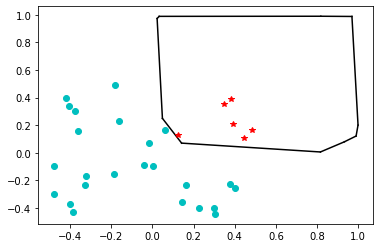

In [15]:
import matplotlib.pyplot as plt
#plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

for p in ps[cond]:
    plt.plot(p[0],p[1],'r*')

for p in ps[~cond]:
    plt.plot(p[0],p[1],'co')

In [16]:
from pryngles import *

In [88]:
sg=Spangler(nspangles=1000)
#sg.populate_spangler(geometry="ring")
sg.populate_spangler(geometry="circle")

<IPython.core.display.Javascript object>


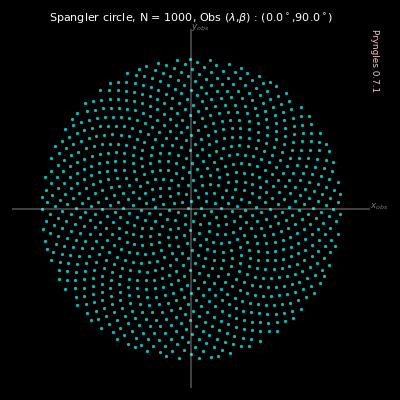

In [89]:
sg.set_observer(n_obs=[0,0,1])
sg.plot_obs()

In [90]:
points=np.array(sg.data[["x_obs","y_obs"]])
points.max(),points.min()

(0.9999589329473952, -0.9999912449033621)

In [91]:
hull = ConvexHull(points)

In [92]:
hull.area,hull.volume

(6.279867290475634, 3.1349604537639726)

<IPython.core.display.Javascript object>


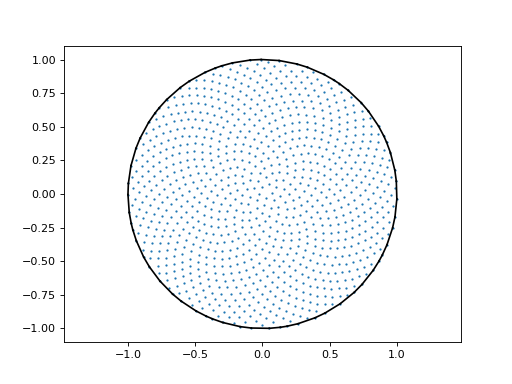

In [93]:
plt.figure()
plt.plot(points[:,0], points[:,1], 'o',ms=1)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.axis("equal");

In [51]:
#Taken from: https://gist.github.com/AndreLester/589ea1eddd3a28d00f3d7e47bd9f28fb
'''
Copyright (C) 2018  Andre Lester Kruger
ConcaveHull.py is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 2 of the License, or
(at your option) any later version.
ConcaveHull.py is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with ConcaveHull.py.  If not, see <http://www.gnu.org/licenses/>.
'''

import bisect
from collections import OrderedDict
import math
#import numpy as np
import matplotlib.tri as tri
from shapely.geometry import LineString
from shapely.geometry import Polygon
from shapely.ops import linemerge


class ConcaveHull:
    
    def __init__(self):
        self.triangles = {}
        self.crs = {}
        
    
    def loadpoints(self, points):
        #self.points = np.array(points)
        self.points = points
        
        
    def edge(self, key, triangle):
        '''Calculate the length of the triangle's outside edge
        and returns the [length, key]'''
        pos = triangle[1].index(-1)
        if pos==0:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][1]]
        elif pos==1:
            x1, y1 = self.points[triangle[0][1]]
            x2, y2 = self.points[triangle[0][2]]
        elif pos==2:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][2]]
        length = ((x1-x2)**2+(y1-y2)**2)**0.5
        rec = [length, key]
        return rec
        
    
    def triangulate(self):
        
        if len(self.points) < 2:
            raise Exception('CountError: You need at least 3 points to Triangulate')
        
        temp = list(zip(*self.points))
        x, y = list(temp[0]), list(temp[1])
        del(temp)
        
        triang = tri.Triangulation(x, y)
        
        self.triangles = {}
        
        for i, triangle in enumerate(triang.triangles):
            self.triangles[i] = [list(triangle), list(triang.neighbors[i])]
        

    def calculatehull(self, tol=50):
        
        self.tol = tol
        
        if len(self.triangles) == 0:
            self.triangulate()
        
        # All triangles with one boundary longer than the tolerance (self.tol)
        # is added to a sorted deletion list.
        # The list is kept sorted from according to the boundary edge's length
        # using bisect        
        deletion = []    
        self.boundary_vertices = set()
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, neigh in enumerate(triangle[1]):
                    if neigh == -1:
                        if pos == 0:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][1])
                        elif pos == 1:
                            self.boundary_vertices.add(triangle[0][1])
                            self.boundary_vertices.add(triangle[0][2])
                        elif pos == 2:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][2])
            if -1 in triangle[1] and triangle[1].count(-1) == 1:
                rec = self.edge(i, triangle)
                if rec[0] > self.tol and triangle[1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
        while len(deletion) != 0:
            # The triangles with the longest boundary edges will be 
            # deleted first
            item = deletion.pop()
            ref = item[1]
            flag = 0
            
            # Triangle will not be deleted if it already has two boundary edges            
            if self.triangles[ref][1].count(-1) > 1:
                continue
                
            # Triangle will not be deleted if the inside node which is not
            # on this triangle's boundary is already on the boundary of 
            # another triangle
            adjust = {0: 2, 1: 0, 2: 1}            
            for i, neigh in enumerate(self.triangles[ref][1]):
                j = adjust[i]
                if neigh == -1 and self.triangles[ref][0][j] in self.boundary_vertices:
                    flag = 1
                    break
            if flag == 1:
                continue
           
            for i, neigh in enumerate(self.triangles[ref][1]):
                if neigh == -1:
                    continue
                pos = self.triangles[neigh][1].index(ref)
                self.triangles[neigh][1][pos] = -1
                rec = self.edge(neigh, self.triangles[neigh])
                if rec[0] > self.tol and self.triangles[rec[1]][1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
            for pt in self.triangles[ref][0]:
                self.boundary_vertices.add(pt)
                                        
            del self.triangles[ref]
            
        self.polygon()
            
                    

    def polygon(self):
        
        edgelines = []
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, value in enumerate(triangle[1]):
                    if value == -1:
                        if pos==0:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][1]]
                        elif pos==1:
                            x1, y1 = self.points[triangle[0][1]]
                            x2, y2 = self.points[triangle[0][2]]
                        elif pos==2:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][2]]
                        line = LineString([(x1, y1), (x2, y2)])
                        edgelines.append(line)

        bound = linemerge(edgelines)
    
        self.boundary = Polygon(bound.coords)

In [55]:
chull=ConcaveHull()
chull.loadpoints(points)
chull.calculatehull()

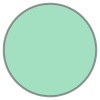

In [56]:
chull.boundary

In [61]:
len(points)

1168

<IPython.core.display.Javascript object>


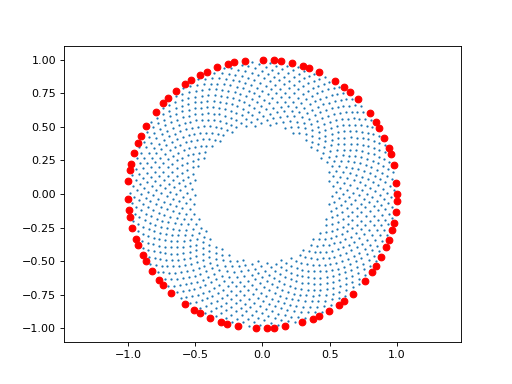

In [63]:
plt.figure()
plt.plot(points[:,0], points[:,1], 'o',ms=1)

"""
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
"""
for convex in chull.boundary_vertices:
    plt.plot(points[convex, 0], points[convex, 1], 'ro')
    
plt.axis("equal");

In [62]:
for c in chull.boundary_vertices:
    print(c)

1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167


In [57]:
chull.boundary_vertices

{1089,
 1090,
 1091,
 1092,
 1093,
 1094,
 1095,
 1096,
 1097,
 1098,
 1099,
 1100,
 1101,
 1102,
 1103,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1118,
 1119,
 1120,
 1121,
 1122,
 1123,
 1124,
 1125,
 1126,
 1127,
 1128,
 1129,
 1130,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,
 1137,
 1138,
 1139,
 1140,
 1141,
 1142,
 1143,
 1144,
 1145,
 1146,
 1147,
 1148,
 1149,
 1150,
 1151,
 1152,
 1153,
 1154,
 1155,
 1156,
 1157,
 1158,
 1159,
 1160,
 1161,
 1162,
 1163,
 1164,
 1165,
 1166,
 1167}

557 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
14.2 µs ± 25.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


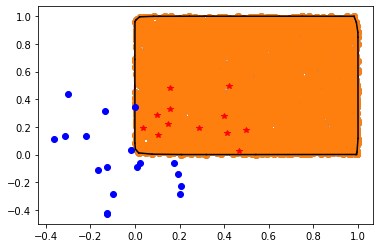

In [1]:



import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')




%timeit points_in_hull(ps,hull)

import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

for p in ps[cond]:
  plt.plot(p[0],p[1],'r*')

for p in ps[~cond]:
  plt.plot(p[0],p[1],'bo')

In [1]:
rho=(xyz[0]**2+xyz[1]**2)**0.5
r=(rho**2+xyz[2]**2)**0.5
theta=np.arctan2(xyz[1],xyz[0])
phi=np.arctan2(xyz[2],rho)

NameError: name 'xyz' is not defined

In [ ]:
def spangle_body(self,seed=0):
    #Create spangler
    self.sp=Spangler(N=self.optics.nspangles)
    
    #Limits of the ring (normalized to re)
    uri=self.ri/self.re
    ure=1
    
    #Generate spangles
    self.sp.gen_ring([
        [0.0,uri],#Internal gap
    ],boundary=0)
    
    #Purge to avoid close-in spangles
    self.sp.purge_sample()
    
    #Generate spangle properties
    self.spangles=np.array([],dtype=Spangle)
    for i in range(self.sp.N):

        #Create spangle
        spangle=Spangle()
        
        #Type of spangles
        spangle.type=GRANULAR_SPANGLE
        
        #Coordinates of the spangle
        xyz_equ=np.append(self.sp.ss[i]*self.re,0) #Complete coordinates with z = 0
        xyz_ecl=spy.mxv(self.M_equ2ecl,xyz_equ) #Rotate to ecliptic coordinates
        
        rqf_equ=np.append(self.sp.pp[i],0) #Complete coordinates with phi = 0
        rqf_equ[0]*=self.re #Scale radial coordinate
        rqf_ecl=sci.xyz2rqf(xyz_ecl) #Convert equatorial to spherical
        
        spangle.set_position([xyz_equ,xyz_ecl],[rqf_equ,rqf_ecl])

        #Unitary vector normal to the spangle
        ns_equ=np.array([0,0,1])
        ns_ecl=spy.mxv(self.M_equ2ecl,ns_equ)
        spangle.set_orientation([ns_equ,ns_ecl])
            
        #Spangle Area
        spangle.asp=self.sp.aes*self.re**2
        
        #Optical properties
        spangle.set_optical(
            albedo_gray_normal=self.optics.albedo_gray_normal,
            tau_gray_optical=self.optics.tau_gray_optical
        )
        
        self.spangles=np.append(self.spangles,copy.deepcopy(spangle))
        del spangle

Ring.spangle_body=spangle_body

In [ ]:
def rotation_matrix(ez,alpha):
    """
    Set a rotation matrix from the direction of the ez vector and a rotation angle alpha
    """
    ex=spy.ucrss([0,0,1],ez) #Spice is 5 faster for vcrss
    if spy.vnorm(ex)==0:
        ex=np.array([1,0,0]) if np.sum(ez)>0 else np.array([-1,0,0])
    ey=spy.ucrss(ez,ex)
    rotation=np.array(list(np.vstack((ex,ey,ez)).transpose())).reshape((3,3))
    rotation_inverse=spy.invert(rotation)
    return rotation,rotation_inverse

Science.rotation_matrix=rotation_matrix

"""
        M_obs2ecl,M_obs2ecl=Science.rotation_matrix(n_obs,alpha_obs)
        self.M_obs2ecl=M_obs2ecl
        self.M_obs2ecl=M_obs2ecl
        print(M_obs2ecl,M_obs2ecl)
""";

## Spangler

In [4]:
from pryngles import *

In [5]:
sg=Spangler(nspangles=500,body_hash="123",n_equ=[0,0,1],n_obs=[1,0,0],n_luz=[1,1,0],center_ecl=[0,0,1])
sg.populate_spangler(geometry="sphere",scale=2,seed=1)
cond=(sg.data.f_equ>0)&((sg.data.q_equ>0)&(sg.data.q_equ<np.pi/2))
sg.data.albedo_gray_normal[cond]=0.1
sg.set_rotation("123",1,0)

In [6]:
%timeit sg.set_luz(n_luz=[1,1,0])

9.3 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [605]:
%timeit sg.set_positions(t=3,n_luz=[1,1,0])

35.1 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


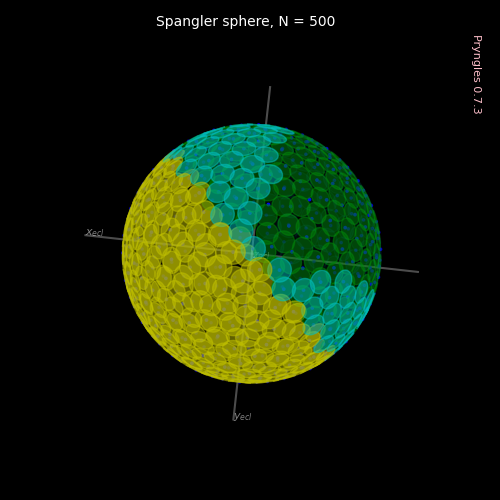

In [604]:
sg.set_positions(t=3,n_luz=[1,1,0])
sg.plot3d(factor=1.3,c='b',s=3)

In [580]:
print_df(sg.data.head(3))

,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,r_ecl,q_ecl,f_ecl,ns_ecl,x_obs,y_obs,z_obs,r_obs,q_obs,f_obs,ns_obs,x_luz,y_luz,z_luz,r_luz,q_luz,f_luz,ns_luz,n_equ,alpha_equ,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit,hidden
0,123,0,3,2,"[0, 0, 0]",-0.078042,-0.099466,-1.996,2.0,4.047099,-1.507540,"[-0.03902113298732534, -0.049732797833878906, -0.9980000000000001]",-0.078042,-0.099466,-1.996,2.0,4.047099,-1.507540,"[-0.03902113298732534, -0.049732797833878906, -0.9980000000000001]",-0.015149,-1.996,-0.125517,2.0,4.704800,-0.062800,"[-0.007574290850795584, -0.9980000000000001, -0.06275850634063525]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",-0.078042,-0.099466,-1.996,2.0,-0.099466,-1.996,"[-0.03902113298732534, -0.049732797833878906, -0.9980000000000001]",1,0,0.100531,0.357771,1.0,0.0,0,0,0,0,0,0,0,0,0
1,123,0,3,2,"[0, 0, 0]",0.215829,0.035690,-1.988,2.0,0.163877,-1.461197,"[0.10791461253655765, 0.01784478638383235, -0.9940000000000001]",0.215829,0.035690,-1.988,2.0,0.163877,-1.461197,"[0.10791461253655765, 0.01784478638383235, -0.9940000000000001]",-0.127378,-1.988,0.177851,2.0,4.648403,0.089043,"[-0.06368898485288552, -0.9940000000000001, 0.08892532377455195]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0.215829,0.035690,-1.988,2.0,0.035690,-1.988,"[0.10791461253655765, 0.01784478638383235, -0.9940000000000001]",1,0,0.100531,0.357771,1.0,0.0,0,0,0,1,0,0,0,0,0
2,123,0,3,2,"[0, 0, 0]",-0.236342,0.154086,-1.980,2.0,2.563841,-1.429257,"[-0.11817105819614698, 0.07704285174370733, -0.99]",-0.236342,0.154086,-1.980,2.0,2.563841,-1.429257,"[-0.11817105819614698, 0.07704285174370733, -0.99]",0.276074,-1.980,-0.058164,2.0,4.850927,-0.029086,"[0.13803707950041097, -0.99, -0.0290820336805604]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",-0.236342,0.154086,-1.980,2.0,0.154086,-1.980,"[-0.11817105819614698, 0.07704285174370733, -0.99]",1,0,0.100531,0.357771,1.0,0.0,0,0,0,0,0,0,0,0,0


In [560]:
sg.data.visible.sum()

250

In [460]:
print_df(sg.data.head(3))

,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,r_ecl,q_ecl,f_ecl,ns_ecl,x_obs,y_obs,z_obs,r_obs,q_obs,f_obs,ns_obs,x_luz,y_luz,z_luz,r_luz,q_luz,f_luz,ns_luz,n_equ,alpha_equ,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,w,q0,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit,hidden
0,123,0,3,2,"[0, 0, 0]",-0.078042,-0.099466,-1.996,2.0,4.047099,-1.507540,"[-0.03902113298732534, -0.049732797833878906, -0.9980000000000001]",-0.078042,-0.099466,-1.996,2.0,4.047099,-1.507540,"[-0.03902113298732534, -0.049732797833878906, -0.9980000000000001]",-0.015149,-1.996,-0.125517,2.0,4.704800,-0.062800,"[-0.007574290850795584, -0.9980000000000001, -0.06275850634063525]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",-0.078042,-0.099466,-1.996,2.0,4.047099,-1.507540,"[-0.03902113298732534, -0.049732797833878906, -0.9980000000000001]",0,0,0,0.100531,0.357771,1,0.0,0,0,0,0,0,0,0,0,0
1,123,0,3,2,"[0, 0, 0]",0.215829,0.035690,-1.988,2.0,0.163877,-1.461197,"[0.10791461253655765, 0.01784478638383235, -0.9940000000000001]",0.215829,0.035690,-1.988,2.0,0.163877,-1.461197,"[0.10791461253655765, 0.01784478638383235, -0.9940000000000001]",-0.127378,-1.988,0.177851,2.0,4.648403,0.089043,"[-0.06368898485288552, -0.9940000000000001, 0.08892532377455195]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0.215829,0.035690,-1.988,2.0,0.163877,-1.461197,"[0.10791461253655765, 0.01784478638383235, -0.9940000000000001]",0,0,0,0.100531,0.357771,1,0.0,0,0,0,1,0,0,0,0,0
2,123,0,3,2,"[0, 0, 0]",-0.236342,0.154086,-1.980,2.0,2.563841,-1.429257,"[-0.11817105819614698, 0.07704285174370733, -0.99]",-0.236342,0.154086,-1.980,2.0,2.563841,-1.429257,"[-0.11817105819614698, 0.07704285174370733, -0.99]",0.276074,-1.980,-0.058164,2.0,4.850927,-0.029086,"[0.13803707950041097, -0.99, -0.0290820336805604]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",-0.236342,0.154086,-1.980,2.0,2.563841,-1.429257,"[-0.11817105819614698, 0.07704285174370733, -0.99]",0,0,0,0.100531,0.357771,1,0.0,0,0,0,0,0,0,0,0,0


In [449]:
cond=(sg.data.dim==3)&(sg.data.z_luz>0)
cond.sum()
sg.data.loc[cond,"illuminated"]=1
sg.data[cond].illuminated
#self.data[cond].illumination=1

1      1
4      1
6      1
7      1
9      1
      ..
493    1
494    1
496    1
498    1
499    1
Name: illuminated, Length: 251, dtype: int64

## Sampler store

In [18]:
sp=Sampler(N=1000)

In [19]:
sp.gen_circle()

In [20]:
import pickle

In [21]:
pickle.dump(sp,open("tmp/pickle.pck","wb"))

In [22]:
#sp.plot()

In [23]:
sg=pickle.load(open("tmp/pickle.pck","rb"))

<IPython.core.display.Javascript object>


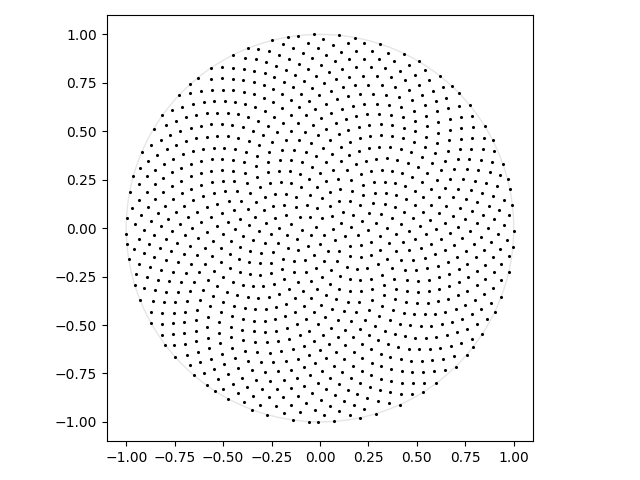

In [24]:
sp.plot()

<IPython.core.display.Javascript object>


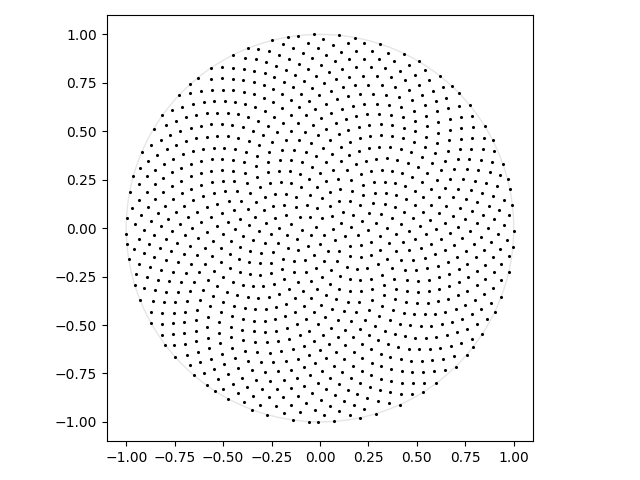

In [25]:
sg.plot()

## Ring Presets

In [3]:
sp=Sampler()

In [4]:
sp.gen_ring()

<IPython.core.display.Javascript object>


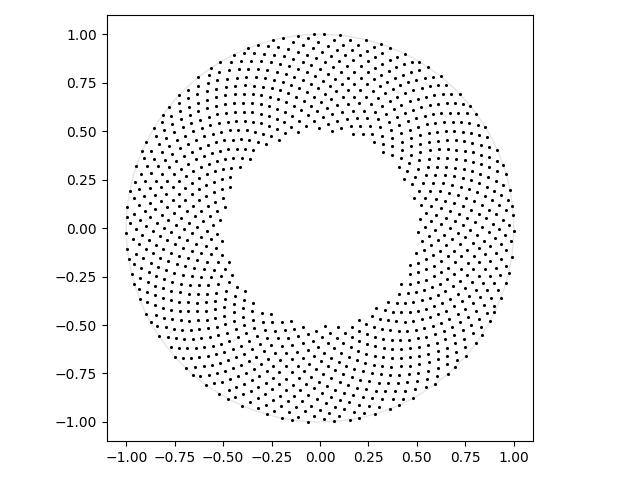

In [5]:
sp.plot()

In [6]:
sp.ss

array([[-0.46964785, -0.17252057,  0.        ],
       [ 0.46345393, -0.19028346,  0.        ],
       [-0.21348407,  0.45396782,  0.        ],
       ...,
       [-0.95774504, -0.28761855,  0.        ],
       [ 0.90049493, -0.43486651,  0.        ],
       [-0.37024882,  0.92893262,  0.        ]])

In [14]:
sp._calc_distances()
sp.dmin,sp.dmax,sp.dran,sp.deff

(0.03543423757182141,
 0.051080629293349715,
 0.015646391721528305,
 0.05068030337996145)

In [17]:
sp.ss

array([[-0.46964785, -0.17252057,  0.        ],
       [ 0.46345393, -0.19028346,  0.        ],
       [-0.21348407,  0.45396782,  0.        ],
       ...,
       [-0.95774504, -0.28761855,  0.        ],
       [ 0.90049493, -0.43486651,  0.        ],
       [-0.37024882,  0.92893262,  0.        ]])

In [20]:
ri=sp.pp[:,0].min()
re=0.8

In [21]:
rs=sp.pp[:,0]

In [22]:
rps=(1-re)/(1-ri)*(rs-ri)+re

In [26]:
sp.pp[:,0]=rps

In [32]:
sp.ss=np.array([list(Science.cartesian(r)) for r in sp.pp])

<IPython.core.display.Javascript object>


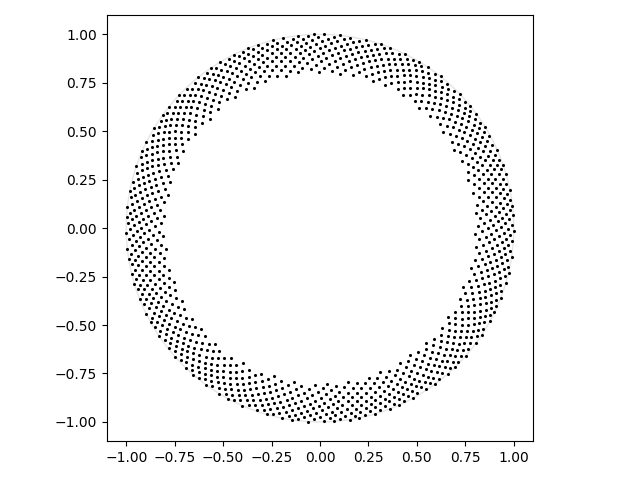

In [33]:
sp.plot()

In [34]:
sp._calc_distances()
sp.dmin,sp.dmax,sp.dran,sp.deff

(0.023994795519667603,
 0.03403341484479156,
 0.010038619325123958,
 0.05068030337996145)

### Rescale ring

0.05255316586388826 0.07537902497670158 0.022825859112813325 0.07179581586177382


<IPython.core.display.Javascript object>


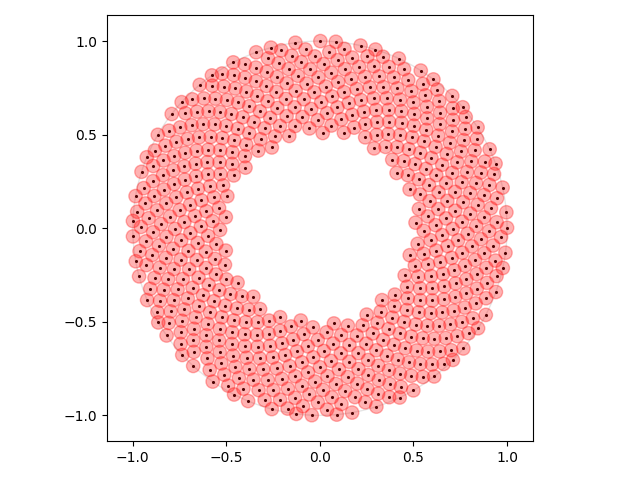

0.053201725724801516 0.08322925368810372 0.0300275279633022 0.07179581586177382


<IPython.core.display.Javascript object>


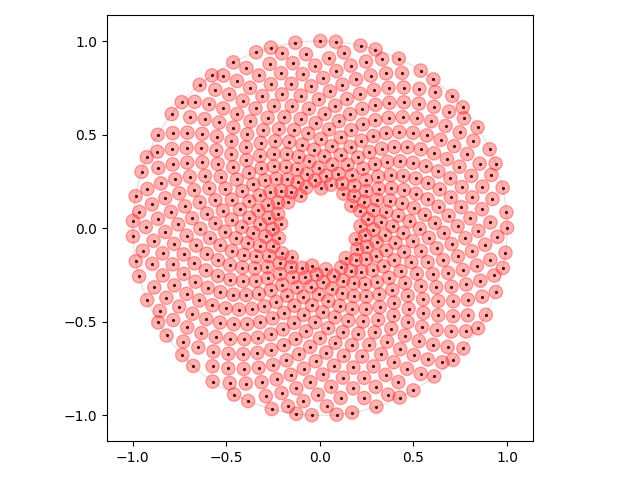

In [41]:
sp=Sampler(N=500)
sp.gen_ring()
print(sp.dmin,sp.dmax,sp.dran,sp.deff)
sp.plot(spangled=dict(color='r'))

#Get ri
ri=sp.pp[:,0].min()

#Scale
re=0.2
rs=sp.pp[:,0]
rps=(1-re)/(1-ri)*(rs-ri)+re
sp.pp[:,0]=rps

#Update cartesian
sp.ss=np.array([list(Science.cartesian(r)) for r in sp.pp])
sp._calc_distances()
print(sp.dmin,sp.dmax,sp.dran,sp.deff)
sp.plot(spangled=dict(color='r'))



In [42]:
sp=Sampler()

<IPython.core.display.Javascript object>


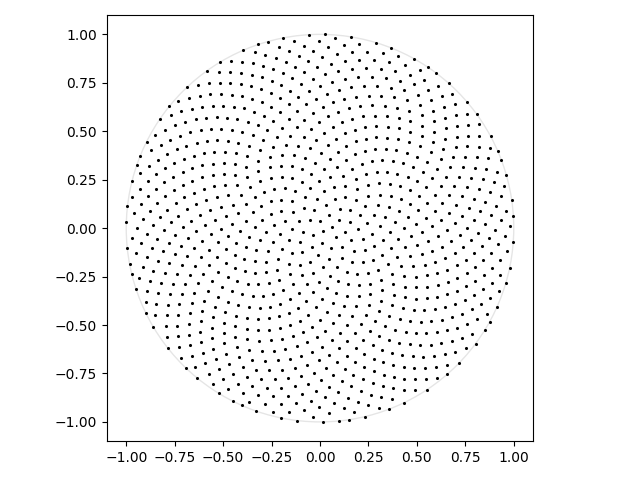

In [44]:
sp.gen_circle()
sp.plot()

In [ ]:
def gen_ring(self,gaps=[[0,0.5]],perturbation=1,boundary=2):
    """
    Sample points in fibonacci spiral on the unit circle, but including gaps (as in rings)

    Parameters:
        gaps: description of the position of gaps in the form [(R1,dR1),(R2,dR2),...], List of tuples.

    Optional parameters:
        perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
        boundary: type of boundary (0 jagged, >1 smooth)

    Example:
        s.Sample(1000)
        s.gen_circle_gaps([(0,0.2),(0.5,0.2),[0.8,0.1]])

    Update:
        ss, pp
    """
    if self.N<100:
        raise ValueError(f"The number of points for a ring shouldn't be lower than 100.  You provided {self.N}")
    
    self._seed_sampler()
    
    #Unitary radius
    self.R=1

    #Total area of the Sample
    self.A=np.pi*self.R**2
    for gap in gaps:
        aminus=np.pi*((gap[0]+gap[1])**2-gap[0]**2)
        self.A-=aminus

    shift = 1.0 if perturbation == 0 else self.N*np.random.random()
    ga = np.pi * (3.0 - np.sqrt(5.0))

    self.dim=2
    Ntest = self.N
    Nacc = 0

    while Nacc < self.N:        

        # Boundary points
        np_boundary = round(boundary * np.sqrt(Ntest))

        ss = []
        pp = []
        j = 0
        for i in range(Ntest):
            if i > Ntest - (np_boundary + 1):
                r = 1.0
            else:
                r = np.sqrt((i + 0.5) / (Ntest - 0.5 * (np_boundary + 1)))

            skip = False
            for gap in gaps:
                if gap[0]<=r<=(gap[0]+gap[1]):
                    skip = True
            if skip:continue

            phi   = ga * (i + shift)
            ss += [np.array([r * np.cos(phi), r * np.sin(phi),0])]
            pp += [np.array([r,np.mod(phi,2*np.pi),0])]
            j += 1
        Nacc = j
        Ntest += int((Ntest-Nacc)/len(gaps))

    self.ss=np.array(ss)
    self.pp=np.array(pp)
    self.N=Nacc

    #Distances
    self._calc_distances()
    
Sampler.gen_ring=gen_ring

In [ ]:
from tqdm import tqdm
for fi,N in tqdm(list(itertools.product(SAMPLER_RINGS_FI_PRESETS,SAMPLER_RINGS_N_PRESETS))):
    sp=Sampler(N=N)
    sp.gen_sphere()
    sp.purge_sample()
    sp.save_to(Misc.get_data(f"sampler_presets/sample_ring_fi_{fi:.3f}_N_{N}.pkl"))

In [27]:
SAMPLER_RINGS_N_PRESETS=np.array(
    list(np.arange(100,1000,100))+\
    list(np.arange(1000,2000,200))+\
    list(np.arange(2000,3000,300))+\
    list(np.arange(3000,4000,400))+\
    list(np.arange(4000,5000,500))+\
    [5000]
)
SAMPLER_RINGS_FI_PRESETS=np.arange(0.0,0.9,0.02)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Colors

In [4]:
from colorsys import hls_to_rgb #See https://pythonfordesigners.com/tutorials/hsl-color-wheel/

In [17]:
def color_sample(H=0):
    fig,ax=plt.subplots(figsize=(9,9))
    dL=0.1
    dS=0.1
    for S in np.arange(0,1+dS,dS):
        for L in np.arange(0,1+dL,dL):
            rgb=hls_to_rgb(H/360,L,S)
            c=Circle((L,S),dL/2.5,color=rgb)
            ax.add_patch(c)
            ax.text(L,S,f"S={S:.1g},L={L:.1g}",ha='center',va='center',fontsize=6,color='y')
    ax.axis("off")
    ax.axis("equal")
    plt.tight_layout()

<IPython.core.display.Javascript object>


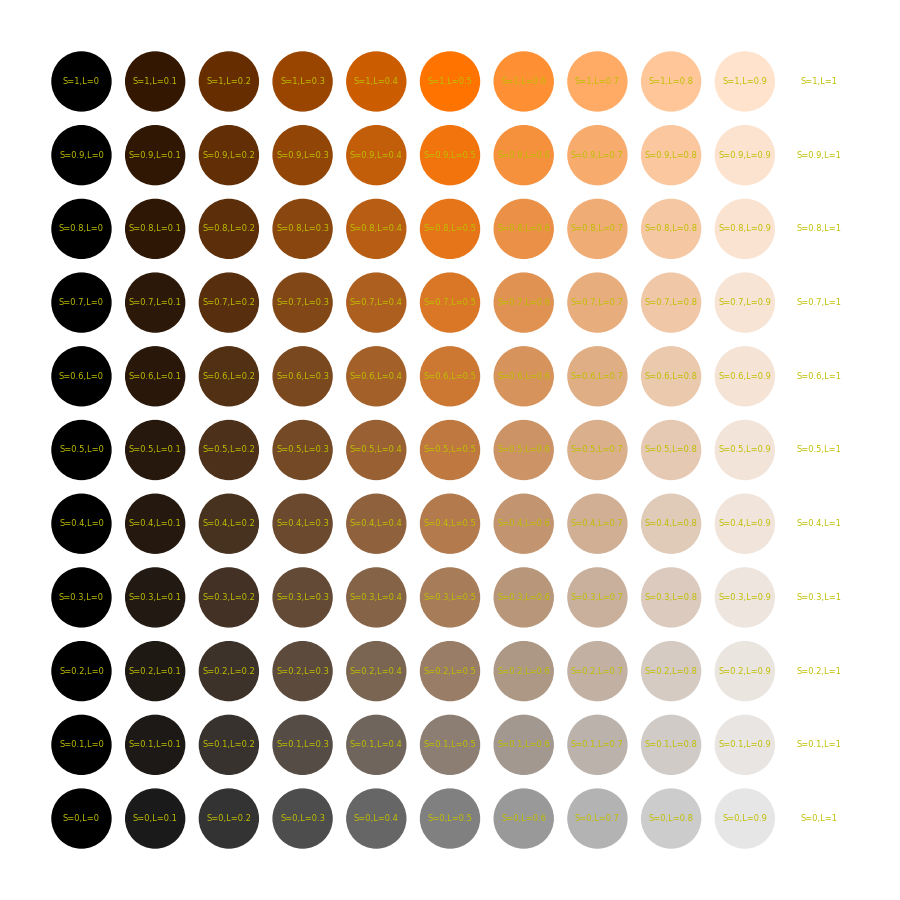

In [18]:
#Planet color
color_sample(27)

<IPython.core.display.Javascript object>


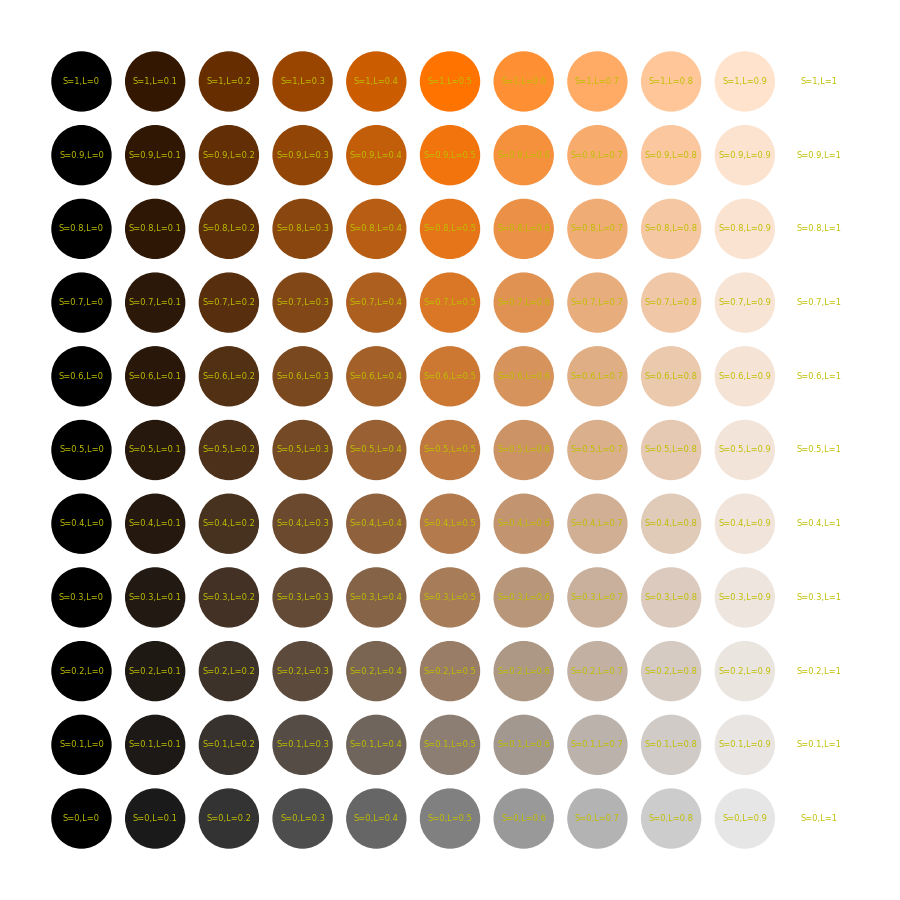

In [73]:
#Planet color
color_sample(27)

<IPython.core.display.Javascript object>


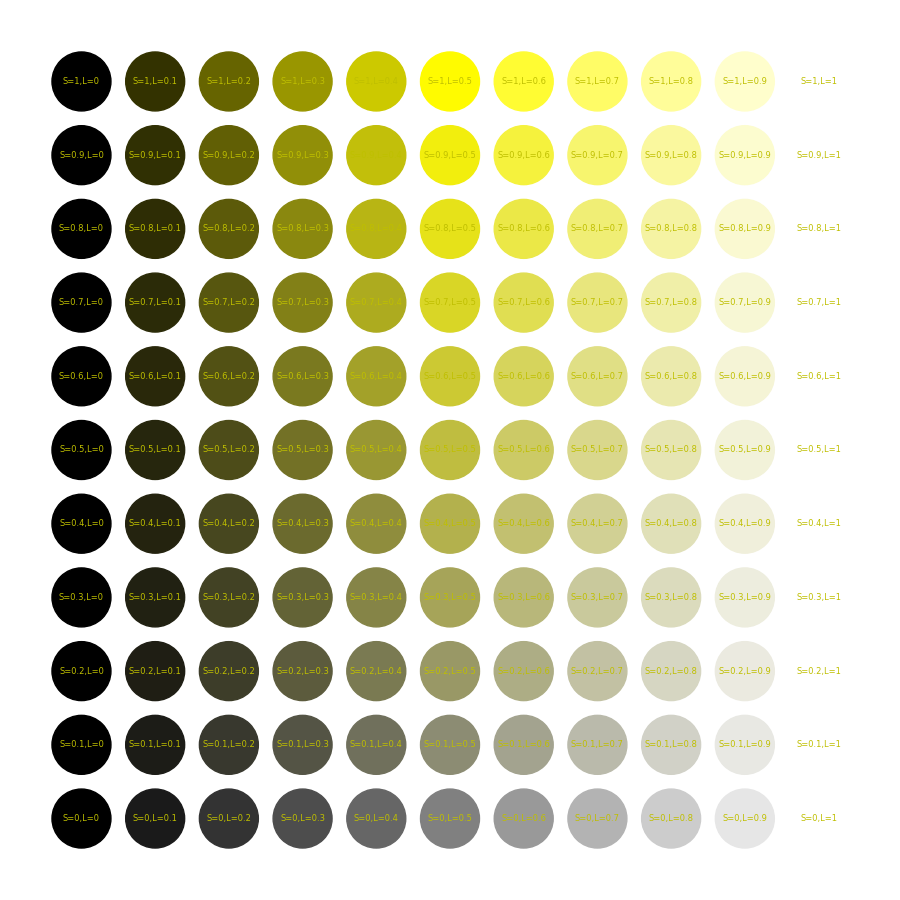

In [74]:
#Stellar color
color_sample(59)

<IPython.core.display.Javascript object>


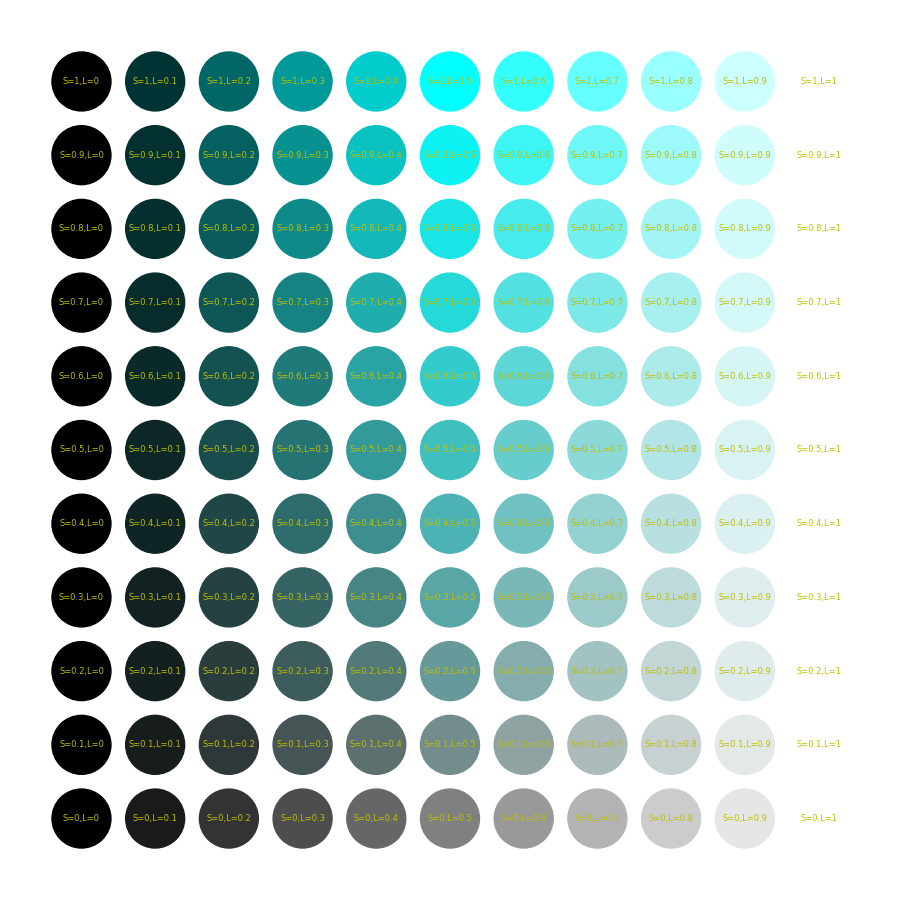

In [75]:
#Ring color
color_sample(180)

In [6]:
color_hls=[27,0.5,1.0]
color_rgb=Misc.rgb(color_hls)
print(color_rgb)
color_hex=Misc.rgb(color_hls,to_hex=True)
print(color_hex)
"""
plt.figure()
plt.axhspan(0,1,color=color_rgb)
plt.axhspan(1,2,color=color_hex)
#""";

(1.0, 0.44999999999999996, 0.0)
#1007300


In [10]:
mh.floor

<function math.floor(x, /)>

In [15]:
"#{:02x}{:02x}{:02x}".format(mh.floor(color_rgb[0]*255),
                                                   int(color_rgb[1]*255),
                                                   int(color_rgb[2]*255))

'#ff7200'

In [ ]:
#Default colors: Given in hue (0-360), level (0: black-1: white), saturation (0-1)
SPANGLE_COLORS=dict()
SPANGLE_COLORS[SOLID_SPANGLE]=[27,0.5,1.0]
SPANGLE_COLORS[ATMOSPHERIC_SPANGLE]=[27,0.5,1.0]
SPANGLE_COLORS[GRANULAR_SPANGLE]=[180,0.8,0.0]
SPANGLE_COLORS[GAS_SPANGLE]=[27,0.5,1.0]
SPANGLE_COLORS[STAR_SPANGLE]=[59,0.7,1.0]
SHADOW_COLOR=[180,0.6,0.0]

#"""
#color_hls=SPANGLE_COLORS[SOLID_SPANGLE]
#color_hls=SPANGLE_COLORS[ATMOSPHERIC_SPANGLE]
#color_hls=SPANGLE_COLORS[GRANULAR_SPANGLE]
#color_hls=SPANGLE_COLORS[GAS_SPANGLE]
color_hls=SPANGLE_COLORS[STAR_SPANGLE]
color_rgb=Misc.rgb(color_hls)
color_hex=Misc.rgb(color_hls,to_hex=True)
plt.figure()
plt.axhspan(0,1,color=color_rgb)
plt.axhspan(1,2,color=color_hex)
#""";

## Deprecated spangle properties

In [ ]:
    "r_ecl":0,"q_ecl":0,"f_ecl":0, #Spherical coordinates of the spangle
    "r_obs":0,"q_obs":0,"f_obs":0, #Spherical coordinates of the spangle
    "ns_obs":[0,0,0], #Unitary vector normal to the spangle, calculated in the class
    "ns_luz":[0,0,0],#Unitary vector normal to the spangle, calculated in the class
mh.isclose(rho,0) else mh.copysign(1,xyz[2])

    #Update spangles orientations
    #AVOIDABLE
    self.data["ns_obs"]=[np.matmul(self.M_ecl2obs,n) for n in self.data["ns_ecl"]]
    
     ([(np.dot(n_ecl,self.n_luz)<0) for n_ecl in self.data.ns_ecl])

        
            #AVOIDABLE
    self.data[["r_ecl","q_ecl","f_ecl"]]=\
        [sci.spherical(r) for r in np.array(self.data[["x_ecl","y_ecl","z_ecl"]])]

    #Update spangles orientations
    self.data["ns_ecl"]=[np.matmul(self.M_equ2ecl,n) for n in self.data.ns_equ]
    
        n_obs: list/array (3), default = []:
            Normal vector towards the observer.
            
        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

        n_luz: list/array (3), default = []:
            Normal vector towards the light-source.


        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

    if len(n_obs)>0:
        self.n_obs,one=spy.unorm(n_obs)

    if len(n_luz)>0:
        self.n_luz,one=spy.unorm(n_luz)
     
    
    #Set observer
    self.set_observer(nvec=self.n_obs,alpha=alpha_obs)
    
    #Set luz
    self.set_luz(nvec=self.n_luz)
